In [1]:
import ppsim
from dataclasses import dataclass
import dataclasses
import numpy as np
from matplotlib import pyplot as plt
import pickle

import ipywidgets as widgets

# CRN (chemical reaction network) notation for specifying protocols



In [2]:
# CRN for approximate majority
a,b,u = pp.species('A B U')
approx_majority = [
    a+b >> 2*u,
    a+u >> 2*a,
    b+u >> 2*b,
]

NameError: name 'pp' is not defined

In [ ]:
n = 10 ** 5
init_config = {a: 0.51*n, b: 0.49*n}
sim = pp.Simulation(init_config, approx_majority)
sim.run(history_interval=0.1)
sim.history.plot()
plt.title('approximate majority protocol')
plt.xlim(0, sim.times[-1])
plt.ylim(0, n)

# DSD oscillator 

Below is an implementation of a rock-paper-scissors (RPS) oscillator using DNA strand displacement. The "formal" CRN for the RPS oscillator is 

- A+B &rarr; 2B
- B+C &rarr; 2C
- C+A &rarr; 2A

Each reaction is implemented by 8 lower-level reactions describing DNA interactions. For details, see Fig. 1 in http://dx.doi.org/10.1126/science.aal2052 (bioRxiv verion: https://www.biorxiv.org/content/10.1101/138420v2).

In [2]:
from ppsim import species

# Fig. 1 in https://www.biorxiv.org/content/10.1101/138420v2.full.pdf
# A+B --> 2B
# B+C --> 2C
# C+A --> 2A

# signal species (represent formal species in formal CRN above)
# index indicates whether it was the first or second product of a previous reaction
b1, b2, c1, c2, a1, a2 = species('b1  b2  c1  c2  a1  a2')

signal_species = [b1, b2, c1, c2, a1, a2]

# fuel species react step
react_a_b_b1, back_a_b = species('react_a_b_b1  back_a_b')
react_b_c_c1, back_b_c = species('react_b_c_c1  back_b_c')
react_c_a_a1, back_c_a = species('react_c_a_a1  back_c_a')

react_species = [react_a_b_b1, react_b_c_c1, react_c_a_a1]
back_species = [back_a_b, back_b_c, back_c_a]

# fuel species produce step
produce_b_b1_b2, helper_b_b2 = species('produce_b_b1_b2  helper_b_b2')
produce_c_c1_c2, helper_c_c2 = species('produce_c_c1_c2  helper_c_c2')
produce_a_a1_a2, helper_a_a2 = species('produce_a_a1_a2  helper_a_a2')

produce_species = [produce_b_b1_b2, produce_c_c1_c2, produce_a_a1_a2]
helper_species = [helper_b_b2, helper_c_c2, helper_a_a2]

# intermediate species
flux_b_b1, flux_c_c1, flux_a_a1 = species('flux_b_b1  flux_c_c1  flux_a_a1')
reactint_a1_b_b1, reactint_b1_c_c1, reactint_c1_a_a1 = species('reactint_a1_b_b1  reactint_b1_c_c1  reactint_c1_a_a1') 
reactint_a2_b_b1, reactint_b2_c_c1, reactint_c2_a_a1 = species('reactint_a2_b_b1  reactint_b2_c_c1  reactint_c2_a_a1') 
productint_b_b1_b2, productint_c_c1_c2, productint_a_a1_a2 = species('productint_b_b1_b2  productint_c_c1_c2  productint_a_a1_a2')

flux_species = [flux_b_b1, flux_c_c1, flux_a_a1]
reactint_species = [reactint_a1_b_b1, reactint_b1_c_c1, reactint_c1_a_a1,
                    reactint_a2_b_b1, reactint_b2_c_c1, reactint_c2_a_a1]
produceint_species = [productint_b_b1_b2, productint_c_c1_c2, productint_a_a1_a2]

# waste species react step
waste_a1_b1, waste_a1_b2, waste_a2_b1, waste_a2_b2 = species('waste_a1_b1  waste_a1_b2  waste_a2_b1  waste_a2_b2')
waste_b1_c1, waste_b1_c2, waste_b2_c1, waste_b2_c2 = species('waste_b1_c1  waste_b1_c2  waste_b2_c1  waste_b2_c2')
waste_c1_a1, waste_c1_a2, waste_c2_a1, waste_c2_a2 = species('waste_c1_a1  waste_c1_a2  waste_c2_a1  waste_c2_a2')

# waste species produce step
waste_b_b1_b2, waste_c_c1_c2, waste_a_a1_a2 = species('waste_b_b1_b2  waste_c_c1_c2  waste_a_a1_a2')

waste_species = [waste_a1_b1, waste_a1_b2, waste_a2_b1, waste_a2_b2,
                 waste_b1_c1, waste_b1_c2, waste_b2_c1, waste_b2_c2,
                 waste_c1_a1, waste_c1_a2, waste_c2_a1, waste_c2_a2,
                 waste_b_b1_b2, waste_c_c1_c2, waste_a_a1_a2]

# DSD reactions implementing formal CRN
# A+B --> 2B
ab_react_rxns = [
    a1 + react_a_b_b1 | back_a_b + reactint_a1_b_b1,
    a2 + react_a_b_b1 | back_a_b + reactint_a2_b_b1,
    reactint_a1_b_b1 + b1 >> waste_a1_b1 + flux_b_b1, # typo in Fig. 1; these rxns irreversible
    reactint_a1_b_b1 + b2 >> waste_a1_b2 + flux_b_b1, #
    reactint_a2_b_b1 + b1 >> waste_a2_b1 + flux_b_b1, #
    reactint_a2_b_b1 + b2 >> waste_a2_b2 + flux_b_b1, #
]
ab_produce_rxns = [
    flux_b_b1 + produce_b_b1_b2 | b1 + productint_b_b1_b2,
    helper_b_b2 + productint_b_b1_b2 >> waste_b_b1_b2 + b2,
]
ab_rxns = ab_react_rxns + ab_produce_rxns

# B+C --> 2C
bc_react_rxns = [
    b1 + react_b_c_c1 | back_b_c + reactint_b1_c_c1,
    b2 + react_b_c_c1 | back_b_c + reactint_b2_c_c1,
    reactint_b1_c_c1 + c1 >> waste_b1_c1 + flux_c_c1,
    reactint_b1_c_c1 + c2 >> waste_b1_c2 + flux_c_c1,
    reactint_b2_c_c1 + c1 >> waste_b2_c1 + flux_c_c1,
    reactint_b2_c_c1 + c2 >> waste_b2_c2 + flux_c_c1,
]
bc_produce_rxns = [
    flux_c_c1 + produce_c_c1_c2 | c1 + productint_c_c1_c2,
    helper_c_c2 + productint_c_c1_c2 >> waste_c_c1_c2 + c2,
]
bc_rxns = bc_react_rxns + bc_produce_rxns

# C+A --> 2A
ca_react_rxns = [
    c1 + react_c_a_a1 | back_c_a + reactint_c1_a_a1,
    c2 + react_c_a_a1 | back_c_a + reactint_c2_a_a1,
    reactint_c1_a_a1 + a1 >> waste_c1_a1 + flux_a_a1,
    reactint_c1_a_a1 + a2 >> waste_c1_a2 + flux_a_a1,
    reactint_c2_a_a1 + a1 >> waste_c2_a1 + flux_a_a1,
    reactint_c2_a_a1 + a2 >> waste_c2_a2 + flux_a_a1,
]
ca_produce_rxns = [
    flux_a_a1 + produce_a_a1_a2 | a1 + productint_a_a1_a2,
    helper_a_a2 + productint_a_a1_a2 >> waste_a_a1_a2 + a2,
]
ca_rxns = ca_react_rxns + ca_produce_rxns

all_rps_dsd_rxns = ab_rxns + bc_rxns + ca_rxns

all_species = signal_species + \
              react_species + \
              back_species + \
              produce_species + \
              helper_species + \
              flux_species + \
              reactint_species + \
              produceint_species + \
              waste_species

 Time: 0.100


(0.0, 691341759248.0)

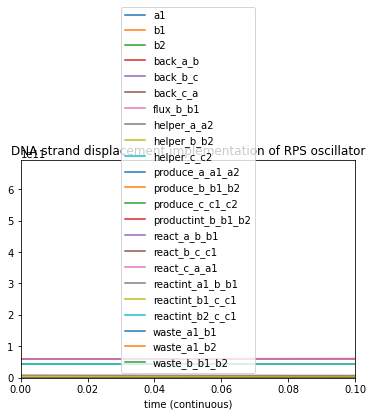

In [6]:
from ppsim import Simulation, RateConstantUnits, concentration_to_count

uL = 10 ** -6  # 1 uL (microliter)
nM = 10 ** -9  # 1 nM (nanomolar)

unit_rate_constants = False
if not unit_rate_constants:
    k = 10e6  # forward rate constant in mass-action units
    r = 10e6  # reverse rate constant in mass-action units
    for rxn in all_rps_dsd_rxns:
        rxn.k(k, units=RateConstantUnits.mass_action)
        if rxn.reversible:
            rxn.r(r, units=RateConstantUnits.mass_action)

vol = 1 * uL

react_conc = 100 * nM
back_conc = 100 * nM
helper_conc = 75 * nM
produce_conc = 100 * nM
a1_conc = 13 * nM
b1_conc = 10 * nM

react_count = concentration_to_count(react_conc, vol)
back_count = concentration_to_count(back_conc, vol)
helper_count = concentration_to_count(helper_conc, vol)
produce_count = concentration_to_count(produce_conc, vol)
a1_count = concentration_to_count(a1_conc, vol)
b1_count = concentration_to_count(b1_conc, vol)

init_config_react = {specie: react_count for specie in react_species}
init_config_back = {specie: back_count for specie in back_species}
init_config_helper = {specie: helper_count for specie in helper_species}
init_config_produce = {specie: produce_count for specie in produce_species}

init_config = {a1: a1_count, b1: b1_count}
init_config.update(init_config_react)
init_config.update(init_config_back)
init_config.update(init_config_helper)
init_config.update(init_config_produce)

volume_for_simulation = 1 if unit_rate_constants else vol
# volume_for_simulation = concentration_to_count(1, vol)
sim = Simulation(init_config=init_config, rule=all_rps_dsd_rxns, volume=volume_for_simulation)
# return sim
sim.run(history_interval=0.01, run_until=0.1)
sim.history.plot()
plt.title('DNA strand displacement implementation of RPS oscillator')
plt.xlim(0, sim.times[-1])
plt.ylim(0, sim.n)